In [ ]:
# Import Packages
from pyspark import SparkConf, SparkContext
from pyspark.ml.linalg import Vectors
import numpy as np
import time
import random
import sys

########################################
# Build the Functions
########################################

# Farthest First Traversal
def farthest_first_traversal(P, k):
    idx_rnd = random.randint(0, len(P)-1)
    S = [P[idx_rnd]]
    related_center_idx = [idx_rnd for i in range(len(P))]
    dist_near_center = [Vectors.squared_distance(P[i], S[0]) for i in range(len(P))]

    for i in range(k-1):    
        new_center_idx = max(enumerate(dist_near_center), key=lambda x: x[1])[0] # argmax operation

        S.append(P[new_center_idx])

        for j in range(len(P)):
            if j != new_center_idx:
                dist = Vectors.squared_distance(P[j], S[-1])
                if dist < dist_near_center[j]:
                    dist_near_center[j] = dist
                    related_center_idx[j] = new_center_idx
            else:
                dist_near_center[j] = 0
                related_center_idx[j] = new_center_idx
    return S

# Run Sequential
def runSequential(points, k):

    n = len(points)
    if k >= n:
        return points

    result = list()
    candidates = np.full(n , True)

    for iter in range(int(k / 2)):
        maxDist = 0.0
        maxI = 0
        maxJ = 0
        for i in range(n):
            if candidates[i] == True:
                for j in range(n):
                    d = Vectors.squared_distance(points[i], points[j])
                    if d > maxDist:
                        maxDist = d
                        maxI = i
                        maxJ = j
        result.append( points[maxI] )
        result.append( points[maxJ] )
        #print "selecting "+str(maxI)+" and "+str(maxJ)
        candidates[maxI] = False
        candidates[maxJ] = False

    if k % 2 != 0:
        s = np.random.randint(n)
        for i in range(n):
            j = (i + s) % n
            if candidates[j] == True:
                #print "selecting "+str(j)
                result.append( points[i] )
                break

    return result

# Run Map Reduce
def runMapReduce(pointsrdd, k, numBlocks):
    
    # Partitioning
    t0 = time.time()
    blocks = pointsrdd.glom()
    
    # Extract k-Points using Farthest-First Traversal algorithm
    centers = blocks.map(lambda p: farthest_first_traversal(p,k))
    
    # Gathering the Vectors
    coreset = [y for c in centers.collect() for y in c]
    t1 = time.time()
    coreset_time = t1-t0
    
    # Results
    t0 = time.time()
    results = runSequential(coreset, k)
    t1 = time.time()
    result_time = t1-t0
    
    return results, coreset_time, result_time

# Measure
def measure(pointslist):
    dist_avg = 0.
    n_points = len(pointslist)
    for i in range(n_points):
        for j in range(i):
            dist_avg += np.sqrt(Vectors.squared_distance(pointslist[i], pointslist[j]))
    dist_avg = dist_avg / (n_points * (n_points-1) / 2)
    
    return dist_avg

########################################
# Use the Functions
########################################

# Spark Setup
conf = SparkConf().setAppName('HW4').setMaster('local[*]')
sc = SparkContext(conf=conf)

# Import the Dataset and Define the Variables
datafile = 'test-datasets/vecs-50-10000.txt'
numBlocks_min, numBlocks_max = 2, 4
k = [2, 3, 4, 5, 6, 7, 8, 9, 10]
numBlocks = [i for i in range(numBlocks_min, numBlocks_max+1)]
k_min, k_max = np.min(k), np.max(k)

inputrdd_list = [[[] for i in range(len(k))] for j in range(len(numBlocks))]
results = [[[] for i in range(len(k))] for j in range(len(numBlocks))]
coreset_times = np.zeros((len(numBlocks), len(k)))
result_times = np.zeros((len(numBlocks), len(k)))
objs = np.zeros((len(numBlocks), len(k)))

for i in range(len(k)):
    for j in range(len(numBlocks)):
        inputrdd = sc.textFile(datafile)\
                                .map(lambda row : Vectors.dense([float(num_str) for num_str in row.split(' ')]))\
                                .repartition(numBlocks[j])\
                                .cache()
        inputrdd_list[j][i] = inputrdd

        # Computations                        
        results[j][i], coreset_times[j,i], result_times[j,i] = runMapReduce(inputrdd, k[i], numBlocks[j])
        objs[j,i] = measure(results[j][i])
        
# Saving Useful Files
np.save('out/coreset_times', coreset_times)
np.save('out/result_times', result_times)
np.save('out/objs', objs)
np.save('out/k', k)
np.save('out/numBlocks', numBlocks)

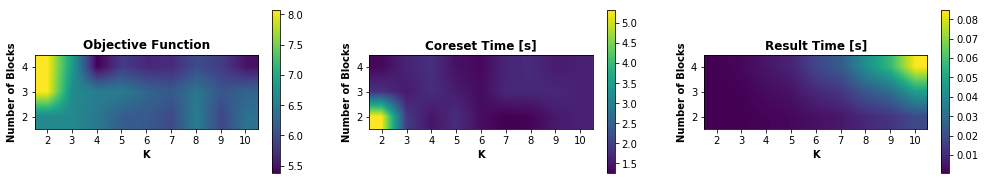

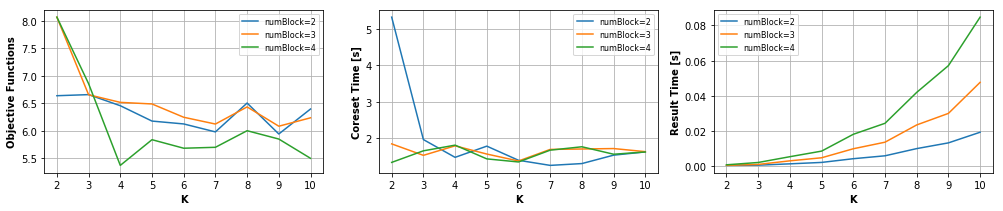

In [5]:
########################################
# Plots
########################################
import matplotlib.pyplot as plt
import numpy as np

# Load Files
coreset_times = np.load('out/coreset_times.npy')
result_times = np.load('out/result_times.npy')
objs = np.load('out/objs.npy')
k = np.load('out/k.npy')
numBlocks = np.load('out/numBlocks.npy')


plt.figure(figsize=(17, 3))
interpolation = 'bilinear'

# Objective Function Plot
plt.subplot(1, 3, 1)
plt.title('Objective Function', fontweight='bold')
plt.imshow(objs, interpolation=interpolation, origin='lower')
plt.colorbar()
plt.xticks(range(len(k)), k)
plt.yticks(range(len(numBlocks)), range(np.min(numBlocks), np.max(numBlocks)+1))
plt.xlabel('K', fontweight='bold')
plt.ylabel('Number of Blocks', fontweight='bold')

# Coreset Time Plot
plt.subplot(1, 3, 2)
plt.title('Coreset Time [s]', fontweight='bold')
plt.imshow(coreset_times, interpolation=interpolation, origin='lower')
plt.colorbar()
plt.xticks(range(len(k)), k)
plt.yticks(range(len(numBlocks)), range(np.min(numBlocks), np.max(numBlocks)+1))
plt.xlabel('K', fontweight='bold')
plt.ylabel('Number of Blocks', fontweight='bold')

# Result Time Plot
plt.subplot(1, 3, 3)
plt.title('Result Time [s]', fontweight='bold')
plt.imshow(result_times, interpolation=interpolation, origin='lower')
plt.colorbar()
plt.xticks(range(len(k)), k)
plt.yticks(range(len(numBlocks)), range(np.min(numBlocks), np.max(numBlocks)+1))
plt.xlabel('K', fontweight='bold')
plt.ylabel('Number of Blocks', fontweight='bold')

plt.show()

numBlocks_list = [i for i in range(np.min(numBlocks), np.max(numBlocks)+1)]
k_list = [i for i in k]

plt.figure(figsize=(17,3))

# Objective Function Plot
plt.subplot(1, 3, 1)
for i in range(len(numBlocks)):
    plt.plot(k_list, objs[i,:], label='numBlock='+str(numBlocks_list[i]))
plt.legend(loc=1, prop={'size':8})
plt.grid(True)
plt.xlabel('K', fontweight='bold')
plt.ylabel('Objective Functions', fontweight='bold')

# Coreset Time Plot
plt.subplot(1, 3, 2)
for i in range(len(numBlocks)):
    plt.plot(k_list, coreset_times[i,:], label='numBlock='+str(numBlocks_list[i]))
plt.legend(loc=1, prop={'size':8})
plt.grid(True)
plt.xlabel('K', fontweight='bold')
plt.ylabel('Coreset Time [s]', fontweight='bold')

# Result Time Plot
plt.subplot(1, 3, 3)
for i in range(len(numBlocks)):
    plt.plot(k_list, result_times[i,:], label='numBlock='+str(numBlocks_list[i]))
plt.legend(loc=2, prop={'size':8})
plt.grid(True)
plt.xlabel('K', fontweight='bold')
plt.ylabel('Result Time [s]', fontweight='bold')

plt.show()